In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

#os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2023-08-08 10:10:36.607962: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 10:10:36.765488: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 10:10:36.767315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 10:10:37.801616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
import pandas as pd
from keras.utils import np_utils

In [8]:
# Read in the training CSV file
print( "Reading Training csv file.")
df1 = pd.read_csv("UNSW_NB15_training-set.csv")
df1.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df1=df1
obj_df1["proto"] = obj_df1["proto"].astype('category')
obj_df1["service"] = obj_df1["service"].astype('category')
obj_df1["state"] = obj_df1["state"].astype('category')
obj_df1["proto_cat"] = obj_df1["proto"].cat.codes
obj_df1["service_cat"] = obj_df1["service"].cat.codes
obj_df1["state_cat"] = obj_df1["state"].cat.codes

obj_df1["proto"] = obj_df1["proto_cat"]
obj_df1["service"] = obj_df1["service_cat"]
obj_df1["state"] = obj_df1["state_cat"]

obj_df1.drop('proto_cat', axis=1, inplace=True)
obj_df1.drop('service_cat', axis=1, inplace=True)
obj_df1.drop('state_cat', axis=1, inplace=True)

Y_train_all_attacks = obj_df1["attack_cat"]
X_train = obj_df1.values[:,:-1]

#Normalizing train set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_train)):
        X_train[i,j] = round(X_train[i,j]/maximum,3)

#Make a catagorical cloumn for each type of label in trainset
obj_df1=pd.get_dummies(obj_df1, columns=["attack_cat"])
Y_train_each_attach = obj_df1.values[:,-10:]
        
# Read in the testing CSV file 
print("Reading Testing csv file.")
df2 = pd.read_csv("UNSW_NB15_testing-set.csv")
df2.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df2=df2
obj_df2["proto"] = obj_df2["proto"].astype('category')
obj_df2["service"] = obj_df2["service"].astype('category')
obj_df2["state"] = obj_df2["state"].astype('category')
obj_df2["proto_cat"] = obj_df2["proto"].cat.codes
obj_df2["service_cat"] = obj_df2["service"].cat.codes
obj_df2["state_cat"] = obj_df2["state"].cat.codes

obj_df2["proto"] = obj_df2["proto_cat"]
obj_df2["service"] = obj_df2["service_cat"]
obj_df2["state"] = obj_df2["state_cat"]

obj_df2.drop('proto_cat', axis=1, inplace=True)
obj_df2.drop('service_cat', axis=1, inplace=True)
obj_df2.drop('state_cat', axis=1, inplace=True)

Y_test_all_attacks = obj_df2["attack_cat"]
X_test = obj_df2.values[:,:-1]

#Normalizing test set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_test)):
        X_test[i,j] = round(X_test[i,j]/maximum,3)
        
#Make a catagorical cloumn for each type of label in testset
obj_df2=pd.get_dummies(obj_df2, columns=["attack_cat"])
Y_test_each_attach = obj_df2.values[:,-10:]

cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
Y_train_all_attacks.replace(cleanup_nums,inplace=True)
Y_test_all_attacks.replace(cleanup_nums,inplace=True)
print('Trainset size: ',X_train.shape,Y_train_all_attacks.shape,'Testset size: ',X_test.shape,Y_test_all_attacks.shape)
Y_train = Y_train_all_attacks 
Y_test = Y_test_all_attacks

# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Reading Training csv file.
Reading Testing csv file.
Trainset size:  (175341, 43) (175341,) Testset size:  (82332, 43) (82332,)
Shape before one-hot encoding:  (175341,)
Shape after one-hot encoding:  (175341, 10)


## Train sparse


In [17]:
import keras

model = Sequential()
model.add(Dense(60, input_shape=(43,)))
model.add(Activation('relu')) 
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
model_losses = []
model_accs = []
class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                    for j in range(0):
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 
            
l_history=LossHistory()
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=50, verbose=1,
          validation_data=(X_test, Y_test), callbacks = [l_history])

loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
model_losses.append(loss_and_metrics[0])
model_accs.append(loss_and_metrics[1])
print(model_losses, model_accs)

Epoch 1/50
1370/1370 [==============================] - 6s 4ms/step - loss: 0.7188 - accuracy: 0.7378 - val_loss: 291357984.0000 - val_accuracy: 0.0912
Epoch 2/50
1370/1370 [==============================] - 6s 4ms/step - loss: 0.5733 - accuracy: 0.7896 - val_loss: 450305024.0000 - val_accuracy: 0.0859
Epoch 3/50
1370/1370 [==============================] - 6s 4ms/step - loss: 0.5408 - accuracy: 0.8042 - val_loss: 267324928.0000 - val_accuracy: 0.1583
Epoch 4/50
1370/1370 [==============================] - 6s 4ms/step - loss: 0.5262 - accuracy: 0.8089 - val_loss: 414513248.0000 - val_accuracy: 0.3147
Epoch 5/50
1370/1370 [==============================] - 6s 4ms/step - loss: 0.5165 - accuracy: 0.8119 - val_loss: 407746176.0000 - val_accuracy: 0.3984
Epoch 6/50
1370/1370 [==============================] - 6s 4ms/step - loss: 0.5098 - accuracy: 0.8122 - val_loss: 314133632.0000 - val_accuracy: 0.3289
Epoch 7/50
1370/1370 [==============================] - 6s 4ms/step - loss: 0.5067 - acc

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.7453488372093023


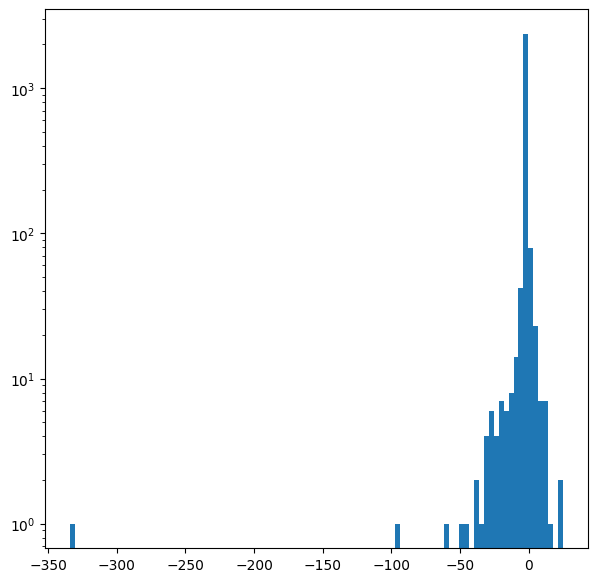

In [18]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

### Unsparsed Model Performance

In [15]:
import keras

Unsparsemodel = Sequential()
Unsparsemodel.add(Dense(60, input_shape=(43,)))
Unsparsemodel.add(Activation('relu')) 
Unsparsemodel.add(Dense(30))
Unsparsemodel.add(Activation('relu'))
Unsparsemodel.add(Dense(10))
Unsparsemodel.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
Unsparsemodel.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
model_losses = []
model_accs = []
            
history = Unsparsemodel.fit(X_train, Y_train,
          batch_size=128, epochs=20, verbose=1,
          validation_data=(X_test, Y_test))

loss_and_metrics = Unsparsemodel.evaluate(X_test, Y_test, verbose=2)
model_losses.append(loss_and_metrics[0])
model_accs.append(loss_and_metrics[1])
print(model_losses, model_accs)

Epoch 1/20
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6343 - accuracy: 0.7645 - val_loss: 936222016.0000 - val_accuracy: 0.4115
Epoch 2/20
1370/1370 [==============================] - 2s 2ms/step - loss: 0.5288 - accuracy: 0.8021 - val_loss: 830519104.0000 - val_accuracy: 0.2233
Epoch 3/20
1370/1370 [==============================] - 2s 2ms/step - loss: 0.4962 - accuracy: 0.8136 - val_loss: 572271936.0000 - val_accuracy: 0.3854
Epoch 4/20
1370/1370 [==============================] - 2s 2ms/step - loss: 0.4811 - accuracy: 0.8180 - val_loss: 965792576.0000 - val_accuracy: 0.1144
Epoch 5/20
1370/1370 [==============================] - 2s 2ms/step - loss: 0.4695 - accuracy: 0.8211 - val_loss: 486151520.0000 - val_accuracy: 0.5958
Epoch 6/20
1370/1370 [==============================] - 2s 2ms/step - loss: 0.4656 - accuracy: 0.8228 - val_loss: 1068108160.0000 - val_accuracy: 0.1288
Epoch 7/20
1370/1370 [==============================] - 2s 2ms/step - loss: 0.4595 - ac

## Check percentage of zeros in this unsparsed model.

% of zeros = 0.0


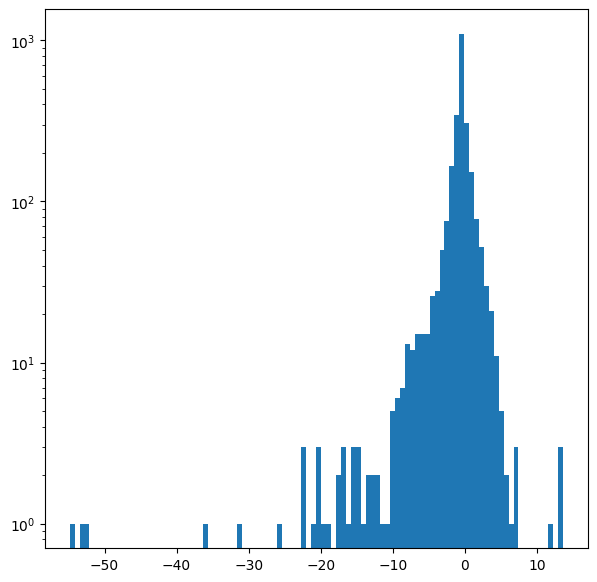

In [19]:
w = Unsparsemodel.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vivado_hls.log`

In [20]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_Sparse_UNSW/hls4ml_prj', part='xc7a200tfbg676-2'
)
hls_model.compile()
hls_model.build(csim=False)

Interpreting Sequential
Topology:
Layer name: dense_22_input, layer type: InputLayer, input shapes: [[None, 43]], output shape: [None, 43]
Layer name: dense_22, layer type: Dense, input shapes: [[None, 43]], output shape: [None, 60]
Layer name: activation_21, layer type: Activation, input shapes: [[None, 60]], output shape: [None, 60]
Layer name: dense_23, layer type: Dense, input shapes: [[None, 60]], output shape: [None, 30]
Layer name: activation_22, layer type: Activation, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: dense_24, layer type: Dense, input shapes: [[None, 30]], output shape: [None, 10]
Layer name: activation_23, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
Interpreting Sequential
Topology:
Layer name: dense_22_input, layer type: InputLayer, input shapes: [[None, 43]], output shape: [None, 43]
La

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config10>' (firmware/nnet_utils/nnet_activation.h:217:46).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config7>' (firmware/nnet_utils/nnet_activation.h:40:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 20

INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_dense_latency.h:17) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_latency.h:18) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'exp_res.V' (firmware/nnet_utils/nnet_activation.h:249) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b8.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_dense_latency.h:17) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_latency.h:18) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_dense_latency.h:17) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_latency.h:18) in dimension 1 c

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:55) by setting 'biases[2].V' to 'b8.V.2'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:55) by setting 'biases[3].V' to 'b8.V.3'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dens

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:47) by setting 'biases[9].V' to 'b5.V.9'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:47) by setting 'biases[10].V' to 'b5.V.10'

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:47) by setting 'biases[27].V' to 'b5.V.27'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[15].V' to 'b2.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[16].V' to 'b2.V.16'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mo

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[33].V' to 'b2.V.33'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' 

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[49].V' to 'b2.V.49'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_

INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:06:09 ; elapsed = 00:06:14 . Memory (MB): peak = 8085.902 ; gain = 7648.027 ; free physical = 4036 ; free virtual = 6695
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:06:19 ; elapsed = 00:06:24 . Memory (MB): peak = 8085.902 ; gain = 7648.027 ; free physical = 4057 ; free virtual = 6700
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_16_6_5_3_0_config8_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<16,6,5,3,0>,config8>.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 5.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.45 seconds; current allocated memory: 376.514 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Ela

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_relu_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 11.13 seconds; current allocated memory: 486.295 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' is 12646 from HDL expression: ((1'b1 == ap_ce_reg) & (1'b0 == ap_block_pp0_stage0_11001))
INFO: 

INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111]  Elapsed time: 2.83 seconds; current allocated memory: 586.416 MB.
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_10ns_16s_26_2_0_MulnS_0'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_13s_16s_26_2_0_MulnS_1'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_7ns_16s_23_2_0_MulnS_2'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_14ns_16s_26_2_0_MulnS_3'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_11ns_16s_26_2_0_MulnS_4'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_8s_16s_24_2_0_MulnS_5'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_15ns_16s_26_2_0_MulnS_6'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_12ns_16s_26_2_0_MulnS_7'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_9s_16s_25_2_0_MulnS_8'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_m

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.105',
  'BestLatency': '48',
  'WorstLatency': '48',
  'IntervalMin': '5',
  'IntervalMax': '5',
  'BRAM_18K': '2',
  'DSP': '1061',
  'FF': '113863',
  'LUT': '32890',
  'AvailableBRAM_18K': '730',
  'AvailableDSP': '740',
  'AvailableFF': '269200',
  'AvailableLUT': '129000'}}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [26]:
hls4ml.report.read_vivado_report('model_Sparse_UNSW/hls4ml_prj/')

Found 1 solution(s) in model_Sparse_UNSW/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Aug  8 10:45:10 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.105|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   48|   48|    5|    5| function |
    +-----+-----+-----+-----+--

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vivado HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

### Compare it with Unsparsed model

In [23]:
config = hls4ml.utils.config_from_keras_model(Unsparsemodel, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    Unsparsemodel, hls_config=config, output_dir='model_UnSparse_UNSW/hls4ml_prj', part='xc7a200tfbg676-2'
)
hls_model.compile()
hls_model.build(csim=False)

Interpreting Sequential
Topology:
Layer name: dense_16_input, layer type: InputLayer, input shapes: [[None, 43]], output shape: [None, 43]
Layer name: dense_16, layer type: Dense, input shapes: [[None, 43]], output shape: [None, 60]
Layer name: activation_15, layer type: Activation, input shapes: [[None, 60]], output shape: [None, 60]
Layer name: dense_17, layer type: Dense, input shapes: [[None, 60]], output shape: [None, 30]
Layer name: activation_16, layer type: Activation, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: dense_18, layer type: Dense, input shapes: [[None, 30]], output shape: [None, 10]
Layer name: activation_17, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
Interpreting Sequential
Topology:
Layer name: dense_16_input, layer type: InputLayer, input shapes: [[None, 43]], output shape: [None, 43]
La

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config10>' (firmware/nnet_utils/nnet_activation.h:217:46).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config7>' (firmware/nnet_utils/nnet_activation.h:40:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 20

INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_dense_latency.h:17) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_latency.h:18) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'exp_res.V' (firmware/nnet_utils/nnet_activation.h:249) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b8.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_dense_latency.h:17) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_latency.h:18) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_dense_latency.h:17) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_latency.h:18) in dimension 1 c

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:55) by setting 'biases[3].V' to 'b8.V.3'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:55) by setting 'biases[4].V' to 'b8.V.4'.
INFO: [XFORM 203-622] Instantiating function 'nn

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:47) by setting 'biases[10].V' to 'b5.V.10'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:47) by setting 'biases[11].V' to

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:47) by setting 'biases[28].V' to 'b5.V.28'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[17].V' to 'b2.V.17'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[18].V' to 'b2.V.18'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[35].V' to 'b2.V.35'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[51].V' to 'b2.V.51'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_

INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:06:58 ; elapsed = 00:07:04 . Memory (MB): peak = 8085.898 ; gain = 7648.027 ; free physical = 4018 ; free virtual = 6730
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:08:20 ; elapsed = 00:08:26 . Memory (MB): peak = 8085.898 ; gain = 7648.027 ; free physical = 3999 ; free virtual = 6724
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_16_6_5_3_0_config8_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<16,6,5,3,0>,config8>.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 7.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 8.01 seconds; current allocated memory: 937.496 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Ela

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_relu_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 63.07 seconds; current allocated memory: 1.243 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' is 49496 from HDL expression: ((1'b1 == ap_ce_reg) & (1'b0 == ap_block_pp0_stage0_11001))
INFO: [R

INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111]  Elapsed time: 5.94 seconds; current allocated memory: 1.504 GB.
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_10s_16s_26_2_0_MulnS_0'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_13s_16s_26_2_0_MulnS_1'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_12ns_16s_26_2_0_MulnS_2'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_10ns_16s_26_2_0_MulnS_3'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_9s_16s_25_2_0_MulnS_4'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_13ns_16s_26_2_0_MulnS_5'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_11ns_16s_26_2_0_MulnS_6'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_8ns_16s_24_2_0_MulnS_7'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul_12s_16s_26_2_0_MulnS_8'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_mul

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.105',
  'BestLatency': '53',
  'WorstLatency': '53',
  'IntervalMin': '5',
  'IntervalMax': '5',
  'BRAM_18K': '2',
  'DSP': '4139',
  'FF': '412489',
  'LUT': '114368',
  'AvailableBRAM_18K': '730',
  'AvailableDSP': '740',
  'AvailableFF': '269200',
  'AvailableLUT': '129000'}}

In [25]:
hls4ml.report.read_vivado_report('model_UnSparse_UNSW/hls4ml_prj/')

Found 1 solution(s) in model_UnSparse_UNSW/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Aug  8 11:04:48 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.105|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   53|   53|    5|    5| function |
    +-----+-----+-----+-----+